In [1]:
%env CUDA_VISIBLE_DEVICES=1
%matplotlib inline

env: CUDA_VISIBLE_DEVICES=1


In [2]:
import numpy as np
import tensorflow as tf
from get_data import get_memristor_data
try: 
    from itertools import izip
except:
    izip = zip
    
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
    
import os
if not os.path.exists('model_params/'):
    os.makedirs('model_params/')
    
import pandas as pd
import scipy
from scipy import optimize, interpolate, stats
from pylab import *

In [3]:
def gauss_interp(mem, samp, xs, ys, interp_width, ratio=0.75):
    """
    Parameters
    ----------
    samp : tf.tensor (batch_size, n_m)
    xs : tf.tensor (n_p, n_m)
        Grid inputs
    ys : tf.tensor (n_p, n_m)
        Grid outputs
    interp_width : float
        Spacing between the xs
    Returns
    -------
    interp_func : tf.tensor (batch_size, n_m)
    """
    samp = tf.expand_dims(samp, 1)  # (batch, 1, n_m)
    xs = tf.cast(tf.expand_dims(xs, 0), tf.float32)  # (1, n_p, n_m)
    ys = tf.cast(tf.expand_dims(ys, 0), tf.float32)  # (1, n_p, n_m)
    sig = np.float32(ratio * interp_width)  # spacing of xs
    norm_factor = np.sqrt(2 * np.pi) * sig / interp_width
    norm_factor = np.array(norm_factor, dtype='float32')
    
    if mem: 
        output = tf.reduce_sum(ys * tf.exp( -0.5 * (samp - xs) ** 2 / sig ** 2) /
                         norm_factor,
                  reduction_indices=1)
    else:
        output = tf.reduce_sum(tf.spectral.dct(ys * tf.exp( -0.5 * (samp - xs) ** 2 / sig ** 2) /
                         norm_factor),
                  reduction_indices=1)
    return output

In [4]:
def memristor_output(v, eps, vs, mus, sigs, interp_width):
    """
    Parameters
    ----------
    mu, sig, eps : tf.tensor (batch_size, n_m)
        mean, standard deviation, noise
    """
    mean = gauss_interp(True, v, vs, mus, interp_width)
    sdev = gauss_interp(True, v, vs, sigs, interp_width)
    return mean + eps * sdev

In [5]:
def _train_graph(
    graph,
    init_op,
    train_op,
    cost_op, # FIXME unused
    summary_dict,
    saver,
    train_data_object,
    summary_data_object,
    feed_vars,
    batch_size,
    num_epochs,
    param_file,
    checkpoint_every_n_epochs,
    global_step,
    save_path='tmp/model.ckpt'
):
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True

    inc_global_step = tf.assign(global_step, global_step + 1)
    with tf.Session(graph=graph, config=config) as sess:
        sess.run(init_op) if param_file is None else saver.restore(sess, param_file)
        for j in range(num_epochs):
            sess.run(inc_global_step)
            train_data_generator = train_data_object.get_generator(batch_size)
            for feed_values in train_data_generator:
                sess.run(
                    train_op,
                    feed_dict=dict(zip(feed_vars, feed_values))
                )

            summary_data_generator = summary_data_object.get_generator()
            for feed_values in summary_data_generator:
                summary_vals = sess.run(summary_dict,
                    feed_dict=dict(zip(feed_vars, feed_values))
                )
                print(
                    'Iteration: {}  '.format(j) +
                    ''.join(['{}: {:0.6f} '.format(k, v) for k, v in
                         summary_vals.items()]))
            if j % checkpoint_every_n_epochs == 0:
                new_save_path = saver.save(
                    sess, save_path, global_step=j)

        new_save_path = saver.save(sess, save_path)
    return new_save_path

In [6]:
def _eval_graph(
    graph,
    saver,
    eval_ops,
    data_object,
    feed_vars,
    param_file):

    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True

    with tf.Session(graph=graph, config=config) as sess:
        saver.restore(sess, param_file)
        data_generator = data_object.get_generator()
        for feed_values in data_generator:
            eval_vals = sess.run(eval_ops,
                feed_dict=dict(zip(feed_vars, feed_values))
            )
    return eval_vals

In [7]:
def random_generator(batch_size, n_features, max_size=10):
    for i in range(max_size):
        yield np.random.randn(batch_size, n_features)

class DataAndNoiseGenerator(object):
    """
    Object that Handles Creation of Data Generators.
    """
    def __init__(self, data_dim, noise_dim, max_size=1):
        self.data_dim = data_dim
        self.noise_dim = noise_dim
        self.max_size = max_size

    def get_generator(self, batch_size=None):
        if batch_size is None:
            batch_size = self.data_dim[0]
        max_size = self.max_size
        input_gen = random_generator(*self.data_dim, max_size=max_size)
        rand_gen = random_generator(*self.noise_dim, max_size=max_size)
        return izip(input_gen, rand_gen)

In [8]:
n_m = 1
old_batch_size = 10000
batch_size = 10000 #used to be 10000
mem_path = 'Data/PCM_20140605.pkl'
pcm_device = 'new'
old_lr = 5e-1
lr = 0.0005 #was 0.0005
num_epochs=301
ratio = 0.75
num_linspace = 300
norm_min = -3.0
norm_max = 3.0 
old_reg_loss_coef = 2.5
reg_loss_coef = 2.5
smoothness_coef = 1.0
optimizer = 'adam'

In [9]:
param_string = (pcm_device+'_'+str(batch_size)+'_'+str(lr)+'_'
                +str(num_epochs)+'_'+str(ratio)
                +'_'+str(num_linspace)+'_'+str(norm_min)
                +'_'+str(norm_max)+'_'+str(reg_loss_coef)
                +'_'+str(smoothness_coef)
                +'_'+optimizer)

In [10]:
old_param_string = (pcm_device+'_'+str(old_batch_size)+'_'+str(old_lr)+'_'
                +str(num_epochs)+'_'+str(ratio)
                +'_'+str(num_linspace)+'_'+str(norm_min)
                +'_'+str(norm_max)+'_'+str(old_reg_loss_coef)
                +'_'+str(smoothness_coef)
                +'_'+optimizer)

In [11]:
vs_data, mus_data, sigs_data, orig_vmin, orig_vmax, orig_rmin, orig_rmax = get_memristor_data(pcm_device = pcm_device, path=mem_path, 
                                                              n_mem=n_m, norm_min=norm_min, 
                                                              norm_max = norm_max)

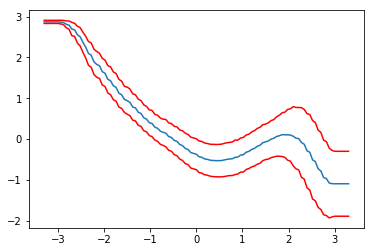

In [12]:
plt.plot(vs_data, mus_data+sigs_data, c='red')
plt.plot(vs_data, mus_data)
plt.plot(vs_data, mus_data-sigs_data, c='red')

In [13]:
def smoother(y):
    return tf.reduce_mean((y[2:] + y[:-2] - 2 * y[1:-1]) ** 2) * smoothness_coef

In [14]:
g = tf.Graph()
with g.as_default():
    tp = tf.placeholder(dtype='float32', shape=(batch_size, n_m))
    # Encoder
    xx = np.linspace(-4, 4, num_linspace)[:, np.newaxis].astype('float32') #20180130: switched to -4,4
    x_encoder = tf.Variable(initial_value=xx, trainable=False)
    y_encoder = tf.Variable(initial_value=xx, trainable=True)

    reg_encoder_loss = smoother(y_encoder)
    
    interp_width=(xx[1] - xx[0])
    t = gauss_interp(True, tp, xs=x_encoder, ys=y_encoder, interp_width=interp_width, ratio=ratio)
#     alpha = tf.Variable(initial_value=1.0, trainable=True)
#     beta = tf.Variable(initial_value=0.0, trainable=True)
#     t = tf.add(tf.multiply(alpha, t_orig), beta)
    #not implementing spectral decomp bc redwood1 doesn't have it
    reg_loss = tf.reduce_mean(tf.reduce_sum(
                      reg_loss_coef * (tf.nn.relu(t - norm_max)
                      + tf.nn.relu(norm_min - t))))

    
    # Channel

    eps = tf.placeholder(dtype='float32', shape=(batch_size, n_m))
    vs, mus, sigs = [tf.Variable(initial_value=_, trainable=False) for _ in [vs_data, mus_data, sigs_data]]

    s = memristor_output(t, eps=eps, vs=vs, mus=mus, sigs=sigs, interp_width=vs_data[1] - vs_data[0])

    # Decoder
    x_decoder = tf.Variable(initial_value=xx, trainable=False)
    y_decoder = tf.Variable(initial_value=xx, trainable=True)

    reg_decoder_loss = smoother(y_decoder)
    sp = gauss_interp(True, s, xs=x_decoder, ys=y_decoder, interp_width=interp_width, ratio=ratio)
#     gamma = tf.Variable(initial_value=1.0, trainable=True)
#     delta = tf.Variable(initial_value=0.0, trainable=True)
#     sp = tf.add(tf.multiply(gamma, sp_orig), delta)
    #not implementing spectral decomp bc redwood1 doesn't have it
    
    rec_loss = tf.reduce_mean((sp - tp) ** 2)
    loss = rec_loss + reg_loss + reg_decoder_loss + reg_encoder_loss

    
    global_step = tf.Variable(0, name='global_step', trainable=False, dtype=tf.int32)
    

    opt = tf.train.AdamOptimizer(lr)
#     opt = tf.train.GradientDescentOptimizer(lr) #see if this works better #20180130: Doesn't seem to work better

    
    train_op = opt.minimize(loss=loss, global_step=global_step)
    summary_dict={'loss': loss, 'reg_dec': reg_decoder_loss, 'reg_enc': reg_encoder_loss, 'reg_loss': reg_loss}
    
    feed_vars=[tp, eps]
    
    saver = tf.train.Saver()
    init_op = tf.global_variables_initializer()

In [15]:
data_gen_train = DataAndNoiseGenerator(data_dim=(batch_size, n_m), noise_dim=(batch_size, n_m), max_size=100)
data_gen_val = DataAndNoiseGenerator(data_dim=(batch_size, n_m), noise_dim=(batch_size, n_m))

In [16]:
## RUN NOTES: 01/29/2018 ###
"""
n_m = 1
old_batch_size = 10000
batch_size = 10000 #used to be 10000
mem_path = 'Data/PCM_20140605.pkl'
pcm_device = 'new'
old_lr = 0.0005
lr = 1e-3 #was 0.0005
num_epochs=300
ratio = 0.75
num_linspace = 300
norm_min = -3.0
norm_max = 3.0 
old_reg_loss_coef = 2.5
reg_loss_coef = 2.5
smoothness_coef = 1.0
optimizer = 'gd'

Has worked well for up to 70 steps (gone down from 2.21 -> 2.02). Will try next do a run with large learning rate
(lr = 5e-3). If this doesn't work I'll go back to the checkpoint at step 70 and let that go more, than lower its
learning rate 

5e-3 worked well, now will try 1e-2.

1e-2 worked well (got down to 1.22 at step 60), now will try 5e-2
5e-2 worked well (got down to 0.80 at step 50), now will try 1e-1
1e-1 worked well (got down to 0.70 at step 40), now will try 5e-1
5e-1 worked well (got down to 0.40 at step 60), now will start this at step 40 and lower lr to 2.5e-1
Didn't work, so I'll try again at step 40 but with lr = 7.5e-1
""";

In [17]:
_train_graph(
    graph=g,
    init_op=init_op,
    train_op=train_op,
    cost_op=None, # FIXME unused
    summary_dict=summary_dict,
    saver=saver,
    train_data_object=data_gen_train,
    summary_data_object=data_gen_val,
    feed_vars=feed_vars,
    batch_size=batch_size,
    num_epochs=num_epochs,
    param_file= None, #switched from None to use step 290 of old run 
    checkpoint_every_n_epochs=10,
    global_step=global_step, save_path='model_params/' + param_string + '.ckpt'
)

Iteration: 0  reg_loss: 17.329424 reg_dec: 0.000003 reg_enc: 0.000030 loss: 19.385105 
Iteration: 1  reg_loss: 9.634825 reg_dec: 0.000006 reg_enc: 0.000121 loss: 11.587727 
Iteration: 2  reg_loss: 5.724915 reg_dec: 0.000006 reg_enc: 0.000243 loss: 7.571332 
Iteration: 3  reg_loss: 9.921510 reg_dec: 0.000005 reg_enc: 0.000365 loss: 11.654578 
Iteration: 4  reg_loss: 11.957805 reg_dec: 0.000005 reg_enc: 0.000492 loss: 13.564611 
Iteration: 5  reg_loss: 11.371012 reg_dec: 0.000007 reg_enc: 0.000639 loss: 12.886313 
Iteration: 6  reg_loss: 5.240071 reg_dec: 0.000007 reg_enc: 0.000792 loss: 6.717678 
Iteration: 7  reg_loss: 5.434165 reg_dec: 0.000009 reg_enc: 0.000933 loss: 6.822960 
Iteration: 8  reg_loss: 11.070312 reg_dec: 0.000012 reg_enc: 0.001085 loss: 12.402081 
Iteration: 9  reg_loss: 5.400684 reg_dec: 0.000014 reg_enc: 0.001225 loss: 6.741900 
Iteration: 10  reg_loss: 5.975027 reg_dec: 0.000018 reg_enc: 0.001350 loss: 7.242271 
Iteration: 11  reg_loss: 4.297931 reg_dec: 0.000022 re

KeyboardInterrupt: 

In [18]:
eval_ops = {
    'tp': tp,
    't': t,
    's': s,
    'sp': sp,
    'y_encoder': y_encoder,
    'y_decoder': y_decoder,
    'mse': rec_loss
}

vals = _eval_graph(
    graph=g,
    saver=saver,
    eval_ops=eval_ops,
    data_object=data_gen_val,
    feed_vars=feed_vars,
    param_file='model_params/' + param_string + '.ckpt-230') #added -150 to get latest checkpoint

INFO:tensorflow:Restoring parameters from model_params/new_10000_0.0005_301_0.75_300_-3.0_3.0_2.5_1.0_adam.ckpt-230


In [19]:
10 * np.log10(1/vals['mse']) 

9.9711162091586942

In [20]:
plot_string = param_string +'.png'

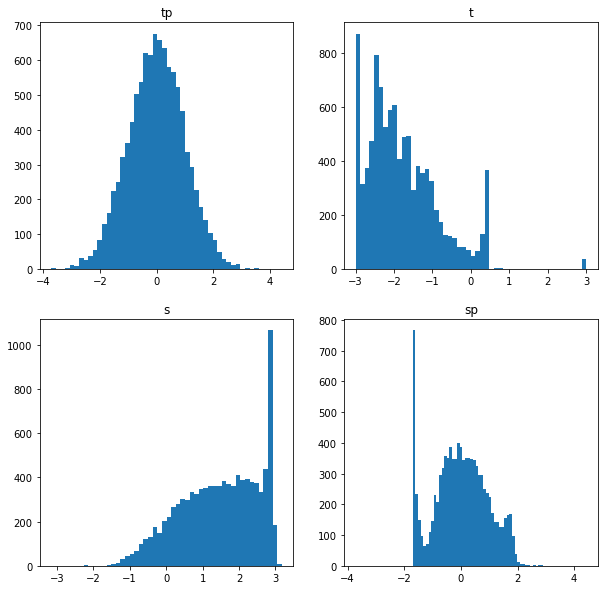

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
for ax, k in zip(axes.flat, ['tp', 't', 's', 'sp']):
    ax.hist(vals[k], bins=50)
    ax.set_title(k)
#     ax.set_yscale('log')
    
_= axes[1,1].set_xlim(*(axes[0, 0].get_xlim()))
if pcm_device == 'new':
    base_name = 'Plots/data_hists_new_'
else: 
    base_name = 'Plots/data_hists_old_'
plt.savefig(base_name+plot_string)

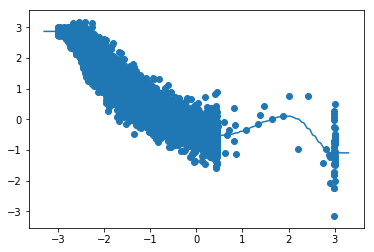

In [22]:
plt.plot(vs_data, mus_data)
plt.scatter(vals['t'], vals['s'])
if pcm_device == 'new':
    base_name = 'Plots/data_scatter_new_'
else: 
    base_name = 'Plots/data_scatter_old_'
plt.savefig(base_name+plot_string)

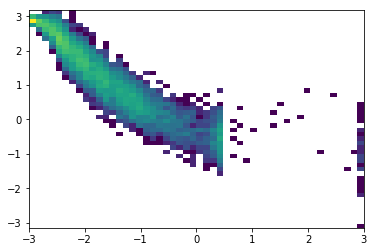

In [23]:
_ = plt.hist2d(vals['t'].ravel(), vals['s'].ravel(), bins=50, norm=LogNorm())

In [24]:
f = interpolate.InterpolatedUnivariateSpline(xx, vals['y_encoder'], k=3)
g = interpolate.InterpolatedUnivariateSpline(vs_data, mus_data, k=3)
h = interpolate.InterpolatedUnivariateSpline(xx, vals['y_decoder'], k=3)

In [25]:
xs = linspace(xx[0][0],xx[-1][0], 1e3)
xs_v = linspace(orig_vmin,orig_vmax, 1e3)
xs_r = linspace(orig_rmin,orig_rmax, 1e3)

/Users/zarcone/anaconda/envs/tensorflow/lib/python3.5/site-packages/ipykernel/__main__.py:1: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':
/Users/zarcone/anaconda/envs/tensorflow/lib/python3.5/site-packages/ipykernel/__main__.py:2: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  from ipykernel import kernelapp as app
/Users/zarcone/anaconda/envs/tensorflow/lib/python3.5/site-packages/ipykernel/__main__.py:3: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  app.launch_new_instance()


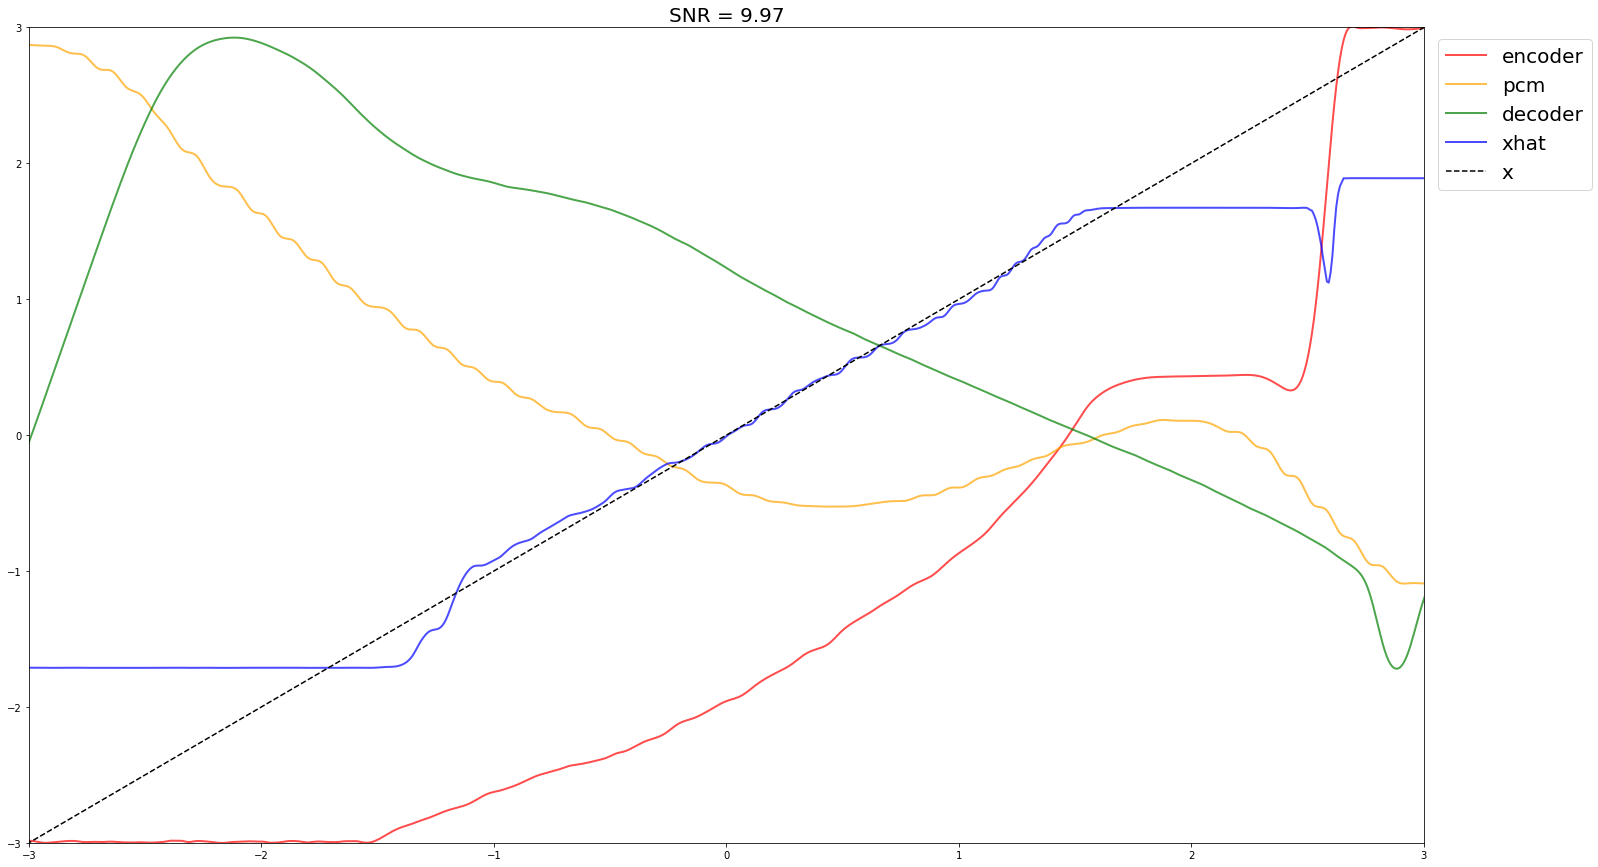

In [30]:
plt.figure(figsize=(25,15))
plt.plot(xs, f(xs), 'r', lw=2, alpha=0.7, label='encoder')
plt.plot(xs, g(xs), c='orange', lw=2, alpha=0.7, label='pcm')
plt.plot(xs, h(xs), c='green', lw=2, alpha=0.7, label='decoder')
plt.plot(xs, h(g(f(xs))), c='blue', lw=2, alpha=0.7, label='xhat')
plt.plot(xx, xx, 'k--', label='x')
plt.xlim(-3.0,3.0)
plt.ylim(-3.0,3.0)
plt.title('SNR = '+str(round(10 * np.log10(1/vals['mse']),2)), fontsize=20)
legend(loc=(1.01,0.8), fontsize=20)

if pcm_device == 'new':
    base_name = 'Plots/enc_dec_plot_new_'
else: 
    base_name = 'Plots/enc_dec_plot_old_'
plt.savefig(base_name+plot_string)

/Users/zarcone/anaconda/envs/tensorflow/lib/python3.5/site-packages/ipykernel/__main__.py:3: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  app.launch_new_instance()


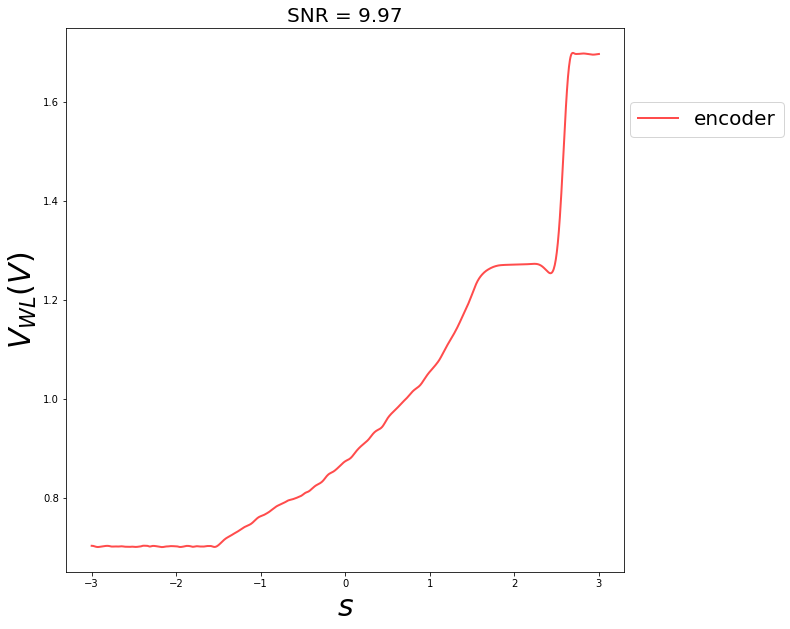

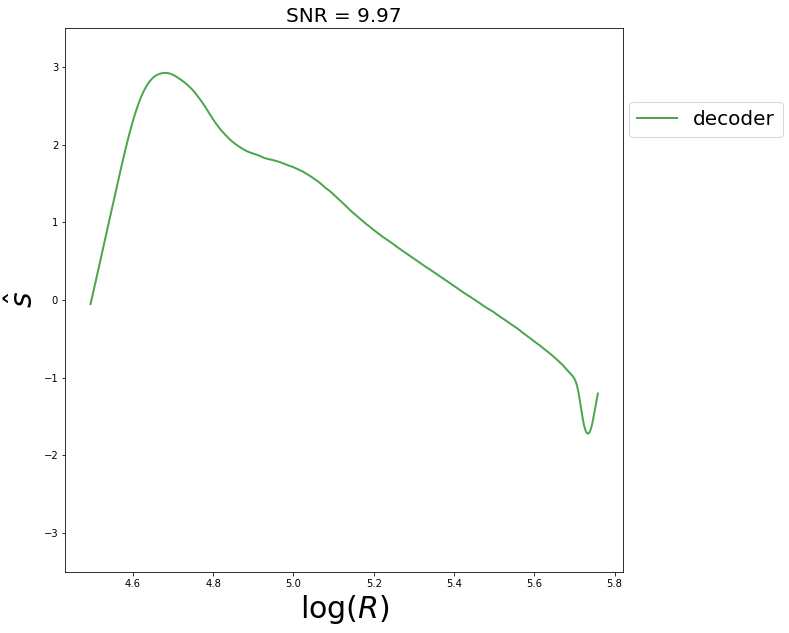

In [51]:
from get_data import normalizer

xs_new = np.linspace(-3,3, 1e3)
figure_thang, (ax1) = plt.subplots(1, figsize=(10,10))
ax1.plot(xs_new, normalizer(f(xs_new),orig_vmin,orig_vmax), 'r', lw=2, alpha=0.7, label='encoder')
ax1.set_aspect('auto')
ax1.set_xlabel(r'$s$', fontsize=30)
ax1.set_ylabel(r'$V_{WL}\left(V\right)$', fontsize=30)

ax1.set_title('SNR = '+str(round(10 * np.log10(1/vals['mse']),2)), fontsize=20)
legend(loc=(1.01,0.8), fontsize=20)


if pcm_device == 'new':
    base_name = 'Plots/enc_plot_new_'
else: 
    base_name = 'Plots/enc_plot_old_'
plt.savefig(base_name+plot_string)

figure_thang, (ax2) = plt.subplots(1, figsize=(10,10))
ax2.plot(xs_r, h(xs_new), c='green', lw=2, alpha=0.7, label='decoder')
ax2.set_title('SNR = '+str(round(10 * np.log10(1/vals['mse']),2)), fontsize=20)
ax2.set_aspect('auto')
ax2.set_ylim(-3.5,3.5)
ax2.set_ylabel(r'$\hat{s}$', fontsize=30)
ax2.set_xlabel(r'$\log\left(R\right)$', fontsize=30)
legend(loc=(1.01,0.8), fontsize=20)

if pcm_device == 'new':
    base_name = 'Plots/dec_plot_new_'
else: 
    base_name = 'Plots/dec_plot_old_'
plt.savefig(base_name+plot_string)

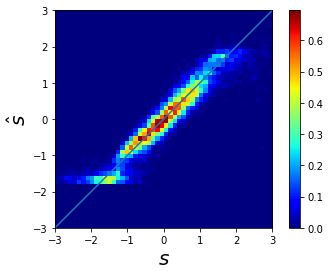

In [35]:
fig = plt.figure()
ax = fig.add_subplot(111)
hist_plot = ax.hist2d(vals['tp'].ravel(), vals['sp'].ravel(), 
              bins=50,cmap='jet', 
              range=np.array([(-3.0, 3.0), (-3.0, 3.0)]), normed='True')
ax.plot(xx,xx)
ax.set_aspect('equal')
plt.colorbar(hist_plot[3],ax=ax)
ax.set_xlabel(r'$s$', fontsize=20)
ax.set_ylabel(r'$\hat{s}$', fontsize=20)

if pcm_device == 'new':
    base_name = 'Plots/x_xhat_hist_new_'
else: 
    base_name = 'Plots/x_xhat_hist_old_'
plt.savefig(base_name+plot_string)